In [1]:
import argparse
import logging
import random
import copy
import pickle
from types import SimpleNamespace
from flwr_datasets import FederatedDataset
from flwr_datasets.visualization import plot_label_distributions

#torch
import torch
from torchvision import transforms

#utils
#from utils.utils_vis import *
from utils.data_utils import *
from utils.train_utils import *
from utils.model import *

/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = SimpleNamespace(
    clients=10,
    batchsize=16,
    isiid=False,
    seed=42,
    alpha=0.07,
    log=True,
    clog=True,
    split=0.2,
    epoch=50,
    lr=0.001,
    device='mps',
    round=50,
    clsplit=0.99,
    data='cifar10',
    plot_label_dist=True,
    k=10,
    ufedproto=True,
    pfl=False,
    ld=0.1,
    momentum=0.95
)

In [3]:
# global model
match args.data:
    case "mnist":
        global_model = MnistNet().to(args.device)
    case "cifar10":
        global_model = Cifar10Net().to(args.device)
    case _:
        raise ValueError(f"Unknown model: {args.data}")

In [4]:
clients = [global_model for _ in range(args.clients)]

In [5]:
torch.manual_seed(args.seed )
global_proto = torch.stack([torch.rand(120) for _ in range(args.k)], dim=0)  # Shape: [k, 120] 
global_proto = global_proto.to(args.device)

In [6]:
_CLIENT = 1

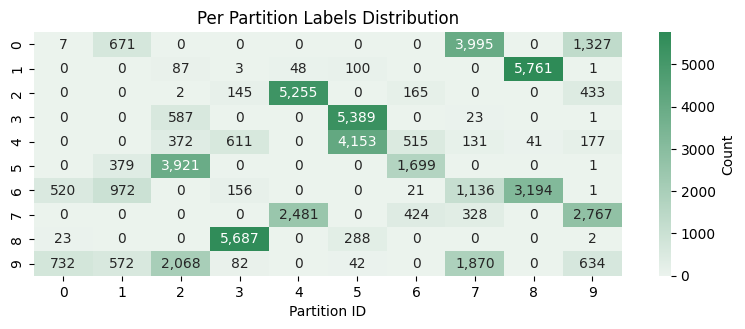

In [7]:
train_loader, testloader = load_dataset(args, _CLIENT)

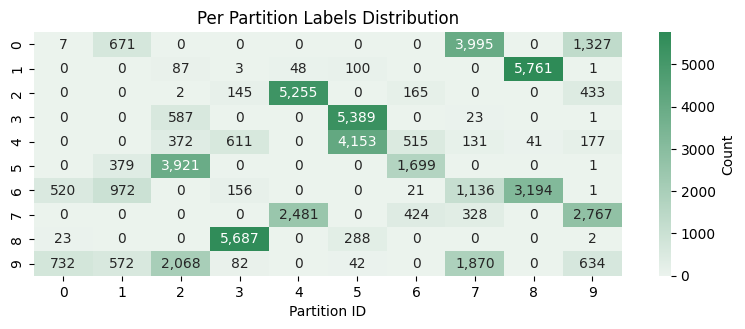

In [8]:
train_loader3, testloader3 = load_dataset(args, 3)

In [9]:
_client_model_trained, protos = train(args, copy.deepcopy(clients[_CLIENT]), train_loader, 0, _CLIENT, global_proto)

Epoch 1: train loss 0.13363590836524963, accuracy 0.28048192771084335, loss1 1.8895058631896973, loss2 0.0015812900383025408
Epoch 2: train loss 0.10837715864181519, accuracy 0.36048192771084336, loss1 1.5629878044128418, loss2 0.0015751798637211323
Epoch 3: train loss 0.09524622559547424, accuracy 0.36048192771084336, loss1 1.426651120185852, loss2 0.0015679739881306887
Epoch 4: train loss 0.08983009308576584, accuracy 0.36048192771084336, loss1 1.3731794357299805, loss2 0.0015658811898902059
Epoch 5: train loss 0.0873718410730362, accuracy 0.36048192771084336, loss1 1.348527431488037, loss2 0.0015741506358608603
Epoch 6: train loss 0.08602245151996613, accuracy 0.36048192771084336, loss1 1.3304269313812256, loss2 0.0015782767441123724
Epoch 7: train loss 0.0849032923579216, accuracy 0.36048192771084336, loss1 1.3079456090927124, loss2 0.0015369016909971833
Epoch 8: train loss 0.08354023844003677, accuracy 0.36626506024096384, loss1 1.276082158088684, loss2 0.0015135897556319833
Epoch

In [71]:
i = 0
acc = 0
for batch in train_loader:
    images, labels = batch["image"], batch["label"]
    images, labels = images.to(args.device), labels.to(args.device)
    _logits, proto = _client_model_trained(images)
    
    probs = F.softmax(_logits, dim=1)
    
    # Get confidence scores and predicted classes
    confidences, predicted_classes = torch.max(probs, dim=1)
    print(labels.shape)
    print(confidences.shape)
    print(proto.shape)
    print("--------------------------")
    print(confidences, predicted_classes)
    # print accuracyt
    acc+=(predicted_classes == labels).float().mean().view(1).item()
    break

torch.Size([16])
torch.Size([16])
torch.Size([16, 120])
--------------------------
tensor([0.9714, 0.5299, 0.5180, 0.7631, 0.6745, 0.9914, 0.5989, 0.9385, 0.9465,
        0.5070, 0.5119, 0.9904, 0.9644, 0.4019, 0.4707, 0.9736],
       device='mps:0', grad_fn=<MaxBackward0>) tensor([6, 0, 9, 0, 0, 6, 0, 6, 6, 9, 6, 6, 6, 6, 6, 6], device='mps:0')


Euclidean Distance: tensor(0.1294, device='mps:0', grad_fn=<DistBackward0>)


In [59]:
euclidean_distance = torch.dist(proto[0], proto[1], p=2)
print("Euclidean Distance:", euclidean_distance)

Euclidean Distance: tensor(0.4441, device='mps:0', grad_fn=<DistBackward0>)


In [82]:
import torch

# Example tensors
t1 = torch.full((4,), 0.5)  # Shape [4] with constant value 2.0
t2 = torch.full((4, 3, 1, 1),4)  # Shape [4, 512, 1, 1]

# Reshape t1 to match the dimensions of t2 for broadcasting
t1_expanded = t1.view(4, 1, 1, 1)

# Perform element-wise multiplication
result = t1_expanded * t2

In [83]:
t2

tensor([[[[4]],

         [[4]],

         [[4]]],


        [[[4]],

         [[4]],

         [[4]]],


        [[[4]],

         [[4]],

         [[4]]],


        [[[4]],

         [[4]],

         [[4]]]])

In [84]:
result

tensor([[[[2.]],

         [[2.]],

         [[2.]]],


        [[[2.]],

         [[2.]],

         [[2.]]],


        [[[2.]],

         [[2.]],

         [[2.]]],


        [[[2.]],

         [[2.]],

         [[2.]]]])

In [86]:
ld = 0.5
for i in range(10):
    print("Round:", i, "LD:", ld, "regularize: ",i/10)

Round: 0 LD: 0.5 regularize:  0.0
Round: 1 LD: 0.5 regularize:  0.1
Round: 2 LD: 0.5 regularize:  0.2
Round: 3 LD: 0.5 regularize:  0.3
Round: 4 LD: 0.5 regularize:  0.4
Round: 5 LD: 0.5 regularize:  0.5
Round: 6 LD: 0.5 regularize:  0.6
Round: 7 LD: 0.5 regularize:  0.7
Round: 8 LD: 0.5 regularize:  0.8
Round: 9 LD: 0.5 regularize:  0.9


In [2]:
import torch
import torch.nn.functional as F

def generate_orthogonal_tensor(num_clients, hidden_neurons, seed=None):
    """
    Generates an orthogonal tensor of shape (num_clients, hidden_neurons).
    
    Args:
        num_clients (int): Number of clients (rows of the tensor).
        hidden_neurons (int): Number of hidden neurons (columns of the tensor).
        seed (int, optional): Seed for reproducibility. Defaults to None.
    
    Returns:
        torch.Tensor: An orthogonal tensor of shape (num_clients, hidden_neurons).
    """
    # Set a global seed for reproducibility if provided
    if seed is not None:
        torch.manual_seed(seed)

    # Generate a random matrix with the desired shape
    init_matrix = torch.randn(num_clients, hidden_neurons)

    # Apply SVD to obtain orthogonal matrices
    u, _, v = torch.svd(init_matrix)

    # Choose u (orthogonal rows) if num_clients <= hidden_neurons
    # Choose v (orthogonal columns) if num_clients > hidden_neurons
    if num_clients <= hidden_neurons:
        orthogonal_tensor = u
    else:
        orthogonal_tensor = v.t()

    # Ensure the tensor has the exact requested shape
    orthogonal_tensor = orthogonal_tensor[:, :hidden_neurons] if orthogonal_tensor.size(1) > hidden_neurons else orthogonal_tensor[:num_clients, :]

    # Optionally normalize each row to have unit length
    orthogonal_tensor = F.normalize(orthogonal_tensor, dim=1)

    # Enable gradients for backpropagation
    orthogonal_tensor.requires_grad_(True)
    
    return orthogonal_tensor

In [3]:
num_clients = 10
hidden_neurons = 120
seed = 42
global_proto = generate_orthogonal_tensor(num_clients, hidden_neurons, seed)
print(global_proto.shape)  # Should output torch.Size([10, 120])

torch.Size([10, 10])


In [5]:
torch.manual_seed(42)
global_proto = torch.stack([2*torch.rand(5)- 1 for _ in range(19)], dim=0)  # Shape: [k, 120]
global_proto_norm = global_proto / torch.norm(global_proto, p=2)

In [8]:
global_proto_norm

tensor([[ 0.1348,  0.1464, -0.0413,  0.1620, -0.0386],
        [ 0.0356, -0.0859,  0.1036,  0.1555, -0.1294],
        [ 0.1533,  0.0330,  0.1303,  0.0239,  0.0850],
        [-0.0249,  0.1359,  0.0261, -0.0823,  0.0449],
        [-0.0812, -0.0207, -0.0716,  0.1170, -0.1392],
        [-0.0813, -0.0498, -0.1060,  0.0166, -0.1742],
        [ 0.1593, -0.1498,  0.1361,  0.0293, -0.0573],
        [ 0.1090,  0.0275,  0.1425,  0.0193, -0.0556],
        [ 0.0474, -0.0478,  0.0742,  0.1574,  0.1019],
        [-0.0771,  0.1018,  0.0316,  0.0896, -0.1075],
        [-0.1746, -0.0681, -0.1353,  0.1447,  0.0508],
        [ 0.0730,  0.0558, -0.0031,  0.1380, -0.1253],
        [ 0.0111, -0.1204,  0.0544, -0.0607,  0.0540],
        [-0.0367,  0.1463, -0.1045, -0.1052, -0.1052],
        [ 0.1586,  0.0588,  0.1697, -0.1455, -0.1749],
        [-0.1380, -0.1186,  0.0714,  0.0631,  0.1465],
        [-0.0911, -0.1202,  0.0936, -0.0713,  0.1070],
        [-0.0418,  0.1009, -0.1370, -0.0890,  0.0538],
        [ 

In [13]:
import torch
import torch.nn.functional as F

# Set a seed for reproducibility
torch.manual_seed(42)

# Generate a square matrix with dimensions [19, 19]
init_matrix = torch.randn(19, 19)

# Apply QR decomposition to ensure orthogonality
q_matrix, _ = torch.torch.linalg.qr(init_matrix)

# Slice to get the desired shape [19, 5]
global_proto = q_matrix[:, :5]

# Normalize each row to have unit length
#global_proto_norm = F.normalize(global_proto, dim=1)

# global_proto_norm is now an orthogonal tensor with shape [19, 5]
print(global_proto)
print(global_proto.shape)  # Should output torch.Size([19, 5])


tensor([[-0.4803,  0.2530,  0.1401,  0.4079, -0.0468],
        [-0.1096, -0.2143,  0.2483, -0.1782, -0.3019],
        [-0.0762, -0.2104, -0.3626, -0.1474,  0.0790],
        [-0.0090, -0.0179,  0.1573,  0.0062, -0.3654],
        [-0.1433, -0.1936, -0.5228,  0.2709, -0.0513],
        [-0.1205, -0.6511,  0.1299, -0.0775,  0.1993],
        [ 0.1493,  0.1542,  0.1802, -0.0684,  0.0929],
        [-0.4076,  0.0641,  0.0820, -0.2972, -0.1007],
        [-0.0869,  0.2189, -0.1294, -0.3985,  0.3307],
        [-0.0130, -0.3866,  0.1931, -0.1303, -0.3360],
        [-0.1755,  0.1337,  0.3863,  0.1349, -0.0760],
        [ 0.2546, -0.0614, -0.1045, -0.0041, -0.1215],
        [ 0.1427,  0.0551,  0.1079, -0.4794, -0.1208],
        [-0.3649,  0.2233, -0.2214, -0.2221, -0.3483],
        [-0.1783, -0.0332,  0.2846, -0.0908,  0.5435],
        [-0.2883, -0.0027, -0.0433, -0.2269,  0.1393],
        [-0.1007, -0.2012,  0.1918,  0.2330,  0.1011],
        [ 0.3623,  0.2025,  0.1209, -0.0422, -0.0401],
        [ 

In [19]:
torch.dot(global_proto[0], global_proto[4])

tensor(0.0595)

In [37]:
# Set a seed for reproducibility
torch.manual_seed(42)

# Generate a square matrix with dimensions [19, 19]
init_matrix = torch.randn(19, 19)

# Apply QR decomposition to ensure orthogonality
q_matrix, _ = torch.qr(init_matrix)
#q_matrix = q_matrix[:, :5]

In [41]:
torch.dot(q_matrix[0], q_matrix[4])

tensor(1.0431e-07)

In [30]:
q_matrix.shape

torch.Size([19, 19])

In [6]:
import torch
import torch.nn.functional as F

# Set a seed for reproducibility
torch.manual_seed(42)

# Generate a square matrix with dimensions [64, 64]
init_matrix = torch.randn(64, 64)
# Apply QR decomposition to ensure orthogonality
q_matrix, _ = torch.linalg.qr(init_matrix)

# Slice to get the desired shape [19, 64]
global_proto = q_matrix[:19, :64]
# Normalize each row to have unit length
global_proto_norm = F.normalize(global_proto, dim=1)
print(torch.max(global_proto_norm), torch.min(global_proto_norm))

tensor(0.4207) tensor(-0.3724)


In [3]:
torch.dot(global_proto_norm[12], global_proto_norm[12])

tensor(1.0000)

In [7]:
global_proto_norm.shape

torch.Size([19, 64])